## Assignment 10AB
In this problem we consider a $1D$ metal rod of length $L$, where the temperature distribution $T(t, x)$ at $t = 0$ is given by a finite sum of sine modes:
$$\begin{align}
T(0,x)&=\sum_{n=1}^N c_n\sin\left(\dfrac{n\pi}{L}x\right)
\end{align}$$
The temperature profile evolves according to the heat equation:
$$\begin{align}
\dfrac{\partial T}{\partial t}&=\alpha\dfrac{\partial^2 T}{\partial x^2}
\end{align}$$
where $\alpha$ is the thermal diffusivity. The boundary conditions are assumed to be the following:
$$\begin{align}
T(t,0)&=0 & T(t,L)&=0
\end{align}$$
The corresponding exact solution for the temperature at any time $t$ is given by:
$$\begin{align}
T(t,x)&=\sum_{n=1}^N c_ne^{-\alpha\left(\tfrac{n\pi}{L}\right)^2 t}\sin\left(\dfrac{n\pi}{L}x\right)
\end{align}$$
Since the Fourier modes with higher $n$ are suppressed exponentially, we expect that the temperature profile is dominated by only a few Fourier components after enough time (regardless of the temperature profile of the rod at $t = 0$). 

In this assignment, you will analyze the time evolution of the system and apply Gaussian Process Regression (GPR) to reconstruct the temperature profile at different times, leveraging this general feature of the heat equation.

**Hint:** Computing the inverse of a matrix is a key step in this assignment. To invert matrices you may use the numerical linear algebra Python library `numpy.linalg.inv`. For example, given a matrix $M$, its inverse can be computed efficiently using:

```python
import numpy as np
M = np.array([[4, 7], [2, 6]])  # Example matrix
M_inv = np.linalg.inv(M)        # Compute the inverse
print(M_inv)
```

### Problem 1 (200 points)
Gaussian Process Regression with Physics-Informed Prior.

To proceed, you may adopt the following parameter choices and initial condition generator:

```python
# Parameters
L = 1.0       # Length of the rod
alpha = 0.01  # Thermal diffusivity
N_modes = 10  # Number of sine modes in the expansion

# Use the specified random generator
rng = np.random.default_rng(42)  # PCG64-based generator with fixed seed

# Generate random Fourier coefficients
c_n = rng.uniform(-1, 1, N_modes)

# Function to compute the initial temperature profile
def initial_temperature(x, L, c_n):
    return sum(c_n[n] * np.sin((n+1) * np.pi * x / L) for n in range(len(c_n)))
```

#### Problem 1.A
Compute the prior covariance matrix $A_{ss'}(t)$, using the physics-informed choice:
$$\begin{align}
A_{ss'}(t)&=e^{\alpha\left(\tfrac{n\pi}{L}\right)^2 t}\delta_{ss'}
\end{align}$$
Compute $A_{ss'}^{-1}$ and use it to construct the kernel function:
$$\begin{align}
K(x,x')&=\sum_{s=1}^N A_{ss}^{-1}\sin\left(\dfrac{s\pi}{L}x\right)\sin\left(\dfrac{s\pi}{L}x'\right)
\end{align}$$
Compute and plot $K(x, x')$ for times $t = 0, 0.25, 0.5, 0.75, 1, 2$.

**Note:** You will be asked to physically motivate this choice of $A_{ss'}$ in Question (d).

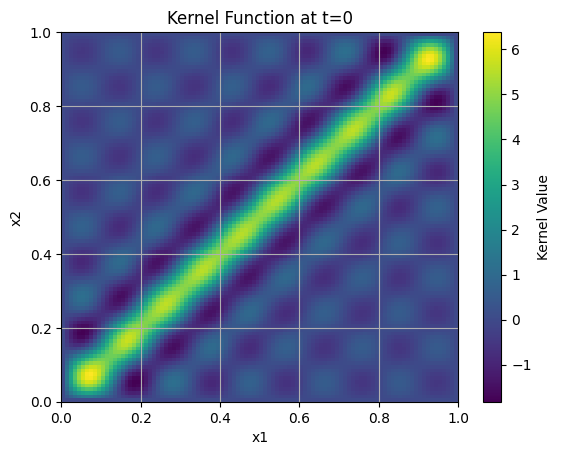

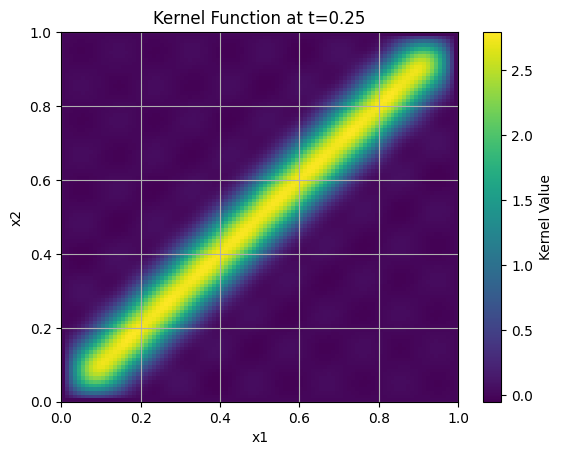

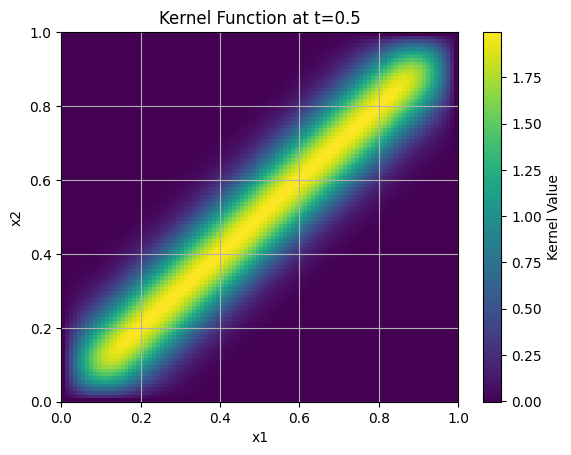

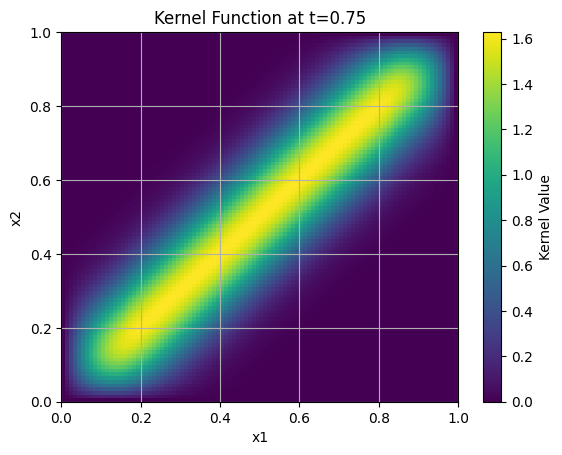

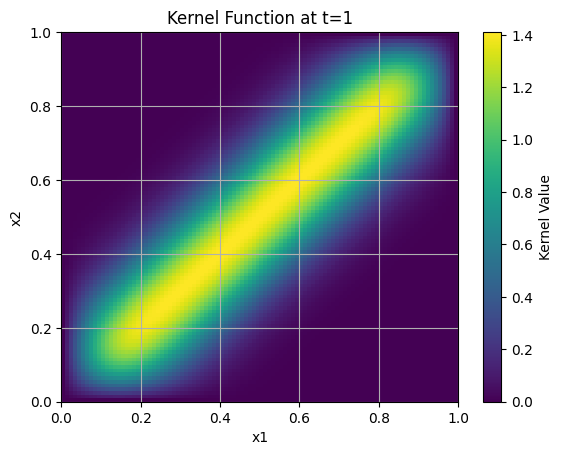

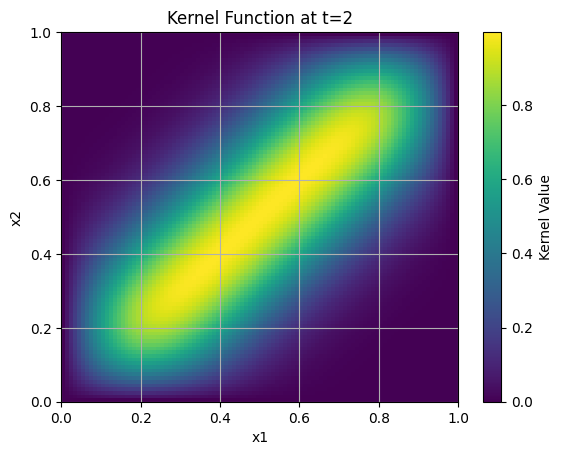

In [139]:
# Imports
import numpy as np
import matplotlib.pyplot as plt


# Parameters class to hold the problem parameters
class ProblemParameters:
    def __init__(self, *, basis_dimension: int = 10, length: float = 1.0, diffusion_constant: float = 0.01):
        self.length: float = length
        self.basis_dimension: int = basis_dimension
        self.diffusion_constant: float = diffusion_constant
        self.measurement_uncertainty: float = 0.01

# CovarianceMatrix class to hold the covariance matrix and its inverse
class CovarianceMatrix:
    def __init__(self, *, time: float, parameters: ProblemParameters):
        self.time = time
        self.parameters = parameters
        self.matrix = self._create()

    def _create(self):

        # Fetch the parameters
        N = self.parameters.basis_dimension
        L = self.parameters.length
        a = self.parameters.diffusion_constant

        # Generate the covariance matrix
        matrix = np.zeros((N, N), dtype=np.float64)
        for s in range(N):
            matrix[s, s] = np.exp(a * self.time * ((s + 1) * np.pi / L) ** 2)

        # Return the covariance matrix
        return matrix

    def inverse(self) -> np.ndarray:
        return np.linalg.inv(self.matrix)

# KernelFunction class to compute the kernel function
class KernelFunction:
    def __init__(self, *, time: float, parameters: ProblemParameters):
        self.time = time
        self.parameters = parameters
        self.matrix_inverse = CovarianceMatrix(time=self.time, parameters=self.parameters).inverse()

    def __call__(self, x1: float, x2: float) -> float:

        # Fetch the parameters
        N = self.parameters.basis_dimension
        L = self.parameters.length

        # Calculate the kernel function
        v1 = np.array([np.sin((s + 1) * np.pi * x1 / L) for s in range(N)])
        v2 = np.array([np.sin((s + 1) * np.pi * x2 / L) for s in range(N)])
        summation = np.sum(self.matrix_inverse * np.outer(v1, v2))
        return summation

# KernelBarMatrix class to compute the kernel bar matrix
class KernelBarMatrix:
    def __init__(self, *, kernel: KernelFunction, samples: np.ndarray, parameters: ProblemParameters):
        self.kernel = kernel
        self.samples = samples
        self.parameters = parameters
        self.matrix = self._create()

    def _create(self) -> np.ndarray:

        # Fetch the parameters
        N = len(self.samples)
        σ = self.parameters.measurement_uncertainty

        # Create the kernel bar matrix
        kernel_bar_matrix = np.zeros((N, N), dtype=np.float64)
        for i in range(N):
            for j in range(N):
                kernel_bar_matrix[i, j] = self.kernel(self.samples[i], self.samples[j])
        return kernel_bar_matrix + (σ ** 2) * np.eye(N)
    
    def inverse(self) -> np.ndarray:
        return np.linalg.inv(self.matrix)


# Assignment of parameters
PARAMETERS = ProblemParameters(
    basis_dimension=10,
    length=1.0,
    diffusion_constant=0.01
)

# Plot the kernel at a few different times
PLOT = True
if PLOT:
    x = np.linspace(0, PARAMETERS.length, 100)
    t_values = [0, 0.25, 0.5, 0.75, 1, 2]
    X1, X2 = np.meshgrid(x, x)
    for t in t_values:

        # Create the kernel function
        kernel = KernelFunction(time=t, parameters=PARAMETERS)

        # Evaluate at a grid of points
        K_values = np.zeros(X1.shape, dtype=np.float64)
        for i in range(X1.shape[0]):
            for j in range(X1.shape[1]):
                K_values[i, j] = kernel(X1[i, j], X2[i, j])

        # Plot the kernel function
        plt.figure()
        plt.imshow(K_values, extent=(0, PARAMETERS.length, 0, PARAMETERS.length), origin='lower', aspect='auto')
        plt.colorbar(label='Kernel Value')
        plt.title(f'Kernel Function at t={t}')
        plt.xlabel('x1')
        plt.ylabel('x2')
        plt.grid()
        plt.show()


#### Problem 1.B
Compute the covariance matrix $\bar{K}_{\alpha\beta}$ for the training data, incorporating the measurement uncertainty $\sigma$:
$$\begin{align}
\bar{K}_{\alpha\beta}&=K(x_\alpha,x_\beta)+\sigma^2\delta_{\alpha\beta}
\end{align}$$
The measurements correspond to temperature values extracted from the provided function at:
$$\begin{align}
x_\alpha&=L/6, L/3, L/2, 2L/3, 5L/6
\end{align}$$
Denoting these measurements as $T_\alpha\equiv T(t,x_\alpha)$, with measurement uncertainty $\sigma = 0.01$, compute the mean prediction:
$$\begin{align}
\braket{T(x)}&=\sum_{\alpha,\beta}K(x,x_\alpha)[\bar{K}^{-1}]_{\alpha\beta}T_\beta
\end{align}$$
and the standard deviation:
$$\begin{align}
\sigma^2_\text{post}(x)&=K(x,x)-\sum_{\alpha,\beta}K(x,x_\alpha)[\bar{K}^{-1}]_{\alpha\beta}K(x_\beta,x)
\end{align}$$

In [140]:
import numpy as np
import matplotlib.pyplot as plt
rng = np.random.default_rng(42)

# Sample points
L = PARAMETERS.length
samples_x = np.array([L/6, L/3, L/2, 2*L/3, 5*L/6])

# Sample temperatures
fourier_coefficents = rng.uniform(-1, 1, PARAMETERS.basis_dimension)
temperature: callable = lambda x: sum(fourier_coefficents[s] * np.sin((s+1) * np.pi * x / L) for s in range(PARAMETERS.basis_dimension))
samples_T = np.array([temperature(x) for x in samples_x])

# Kernel function
TIME = 0.5
kernel = KernelFunction(time=TIME, parameters=PARAMETERS)

# Kernel bar matrix
KernelBarMatrixInverse = KernelBarMatrix(kernel=kernel, samples=samples_x, parameters=PARAMETERS).inverse()

# Calculate the mean
def mean(x: float, x_samples, T_samples, kernel) -> float:
    KernelBarMatrixInverse = KernelBarMatrix(kernel=kernel, samples=x_samples, parameters=PARAMETERS).inverse()
    summation = 0.0
    for i in range(len(x_samples)):
        for j in range(len(x_samples)):
            summation += kernel(x, x_samples[i]) * KernelBarMatrixInverse[i, j] * T_samples[j]
    return summation

# Calculate the variance
def variance(x: float, x_samples, kernel) -> float:
    KernelBarMatrixInverse = KernelBarMatrix(kernel=kernel, samples=x_samples, parameters=PARAMETERS).inverse()
    summation = 0.0
    for i in range(len(x_samples)):
        for j in range(len(x_samples)):
            summation += kernel(x, x_samples[i]) * KernelBarMatrixInverse[i, j] * kernel(x_samples[j], x)
    return kernel(x, x) - summation


#### Problem 1.C
Perform the GPR reconstruction for the same times as the kernel calculations: $t = 0, 0.25, 0.5, 0.75, 1, 2$. Plot the predicted mean temperature profile $\braket{T(x)}$ for each case along with the standard deviation confidence interval (error bars). Compare the reconstructed function to the true solution of the heat equation at the corresponding time.

**Note:** You are allowed to use any language model of choice (Chat-GPT, Claude, DeepSeek, etc...) to display the standard deviation as a shaded area around the GPR prediction, in a similar fashion as in the plots of the lecture notes. Note that the use of language models is permitted exclusively for learning how to edit the plot nicely, but not for solving the problem.

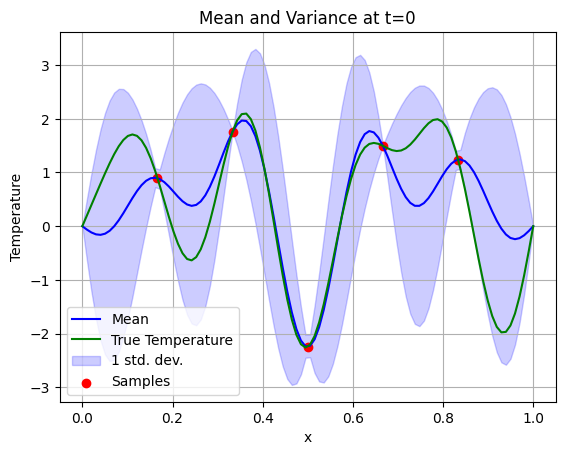

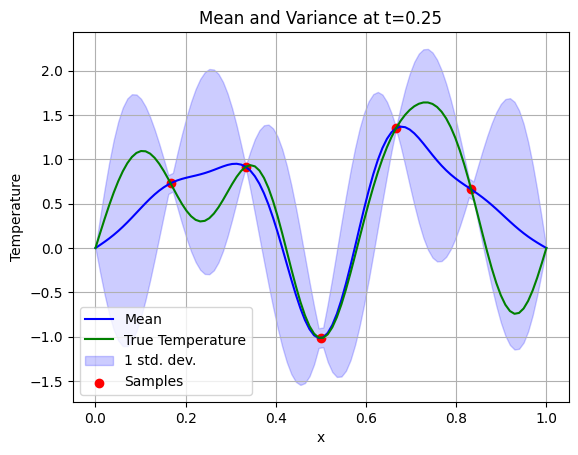

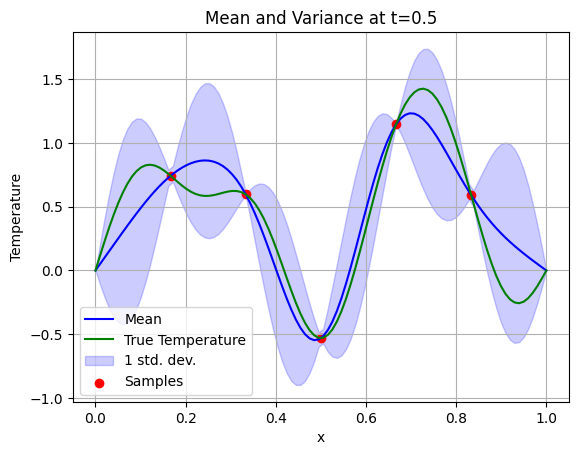

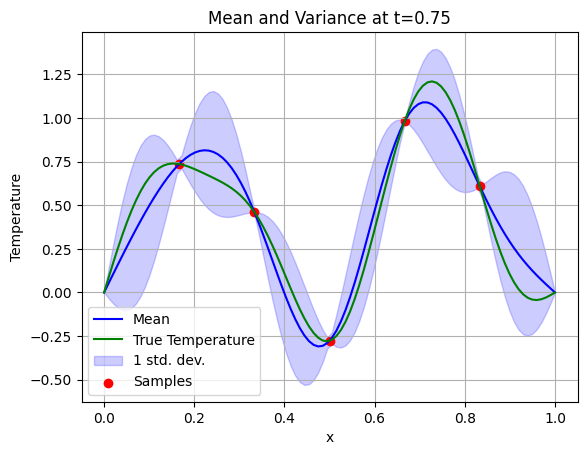

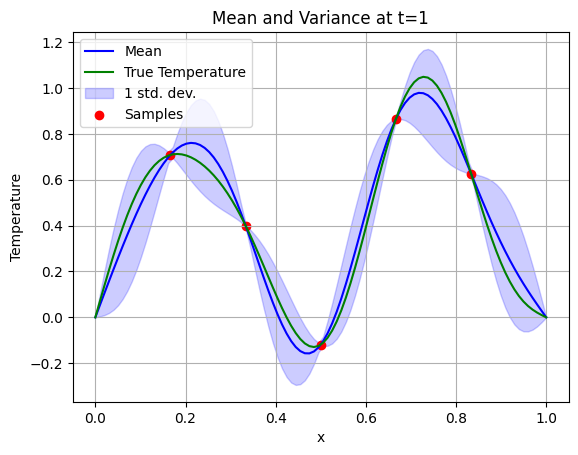

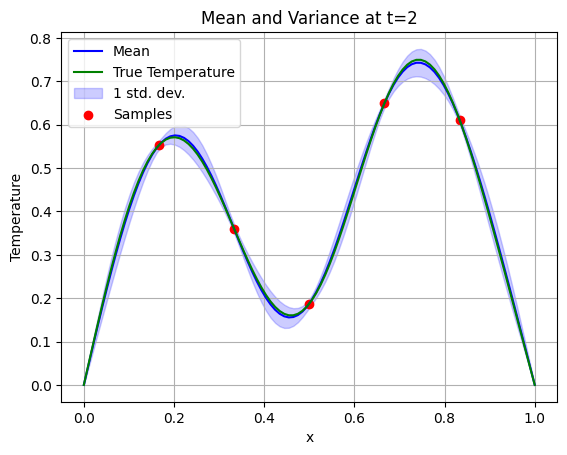

In [141]:
import numpy as np
import matplotlib.pyplot as plt
rng = np.random.default_rng(42)

# Sample points
L = PARAMETERS.length
nsx = 6
samples_x = np.array([i/nsx for i in range(1, nsx)])

# Sample temperatures
fourier_coefficents = rng.uniform(-1, 1, PARAMETERS.basis_dimension)


# Loop through different times
def temp_distr(a,x,t, L, c_n):
    return sum(c_n[n] * np.exp(-a*t*(((n*np.pi)/L))**2) *np.sin((n+1) * np.pi * x / L) for n in range(len(c_n)))

x = np.linspace(0, PARAMETERS.length, 100)
for t in [0, 0.25, 0.5, 0.75, 1, 2]:

    # Sample temperatures
    temperature: callable = lambda x, t: sum(fourier_coefficents[s] * np.exp(-PARAMETERS.diffusion_constant*t*(((s*np.pi)/L))**2) * np.sin((s+1) * np.pi * x / L) for s in range(PARAMETERS.basis_dimension))
    samples_T = np.array([temperature(x, t) for x in samples_x])

    # Kernel function
    kernel = KernelFunction(time=t, parameters=PARAMETERS)

    # Kernel bar matrix
    mean_list = [mean(x=_, x_samples=samples_x, T_samples=samples_T, kernel=kernel) for _ in x]
    var_list = [variance(x=_, x_samples=samples_x, kernel=kernel) for _ in x]

    # Plot the mean and variance
    plt.figure()
    plt.plot(x, mean_list, label='Mean', color='blue')
    plt.plot(x, temp_distr(PARAMETERS.diffusion_constant, x, t, PARAMETERS.length, fourier_coefficents), label='True Temperature', color='green')
    plt.fill_between(x, np.array(mean_list) - np.sqrt(var_list), np.array(mean_list) + np.sqrt(var_list), color='blue', alpha=0.2, label='1 std. dev.')
    # plt.fill_between(x, np.array(mean_list) - 2 * np.sqrt(var_list), np.array(mean_list) + 2 * np.sqrt(var_list), color='blue', alpha=0.1, label='2 std. dev.')
    plt.scatter(samples_x, samples_T, color='red', label='Samples')
    plt.title(f'Mean and Variance at t={t}')
    # plt.ylim(-3.5,3.5)
    plt.xlabel('x')
    plt.ylabel('Temperature')
    plt.legend()
    plt.grid()
    plt.show()


#### Problem 1.D
In the Jupyter Notebook, provide a brief explanation in markdown discussing the role of the prior covariance matrix $A_{ss'}$ in the Gaussian Process Regression model. Explain how the structure of $A_{ss'}$ encodes the expected physical behavior of the system and why this choice is justified based on the heat equation. Additionally, comment on the agreement between the reconstructed function and the actual temperature profile as a function of time.

> The structure of $A_{ss'}$ is a diagonal matrix because the basis elements are independent of each other. Therefore, on the diagonal it encodes the magnitude of the elements, and its inverse is 1/magnitude. Given that the heat equation can be represented as a fourier linear series, it's evident that the covariant matrix must also be diagonal given the orthogonality of basis elements.

> At the points that we measure, the difference between the mean value calculated and the true value are significantly small, since our standard devation requirement of 0.01 leads to very very precise evaluation at those points, and the further away we get between chosen data points the variance becomes higher since there are more options of functions that go between those points when they're far away from certainty evaluations.

> The standard deviation decreases as time progresses since the high-frequency components of the waves die fast, and so the space of available functions decreases relatively quickly. This why at $t=0$ it has the highest variance, and later on as it thermalizes it tends toward 0 variance.